# **Emotion Analysis**

# Importing Libraries and Dependencies

In [1]:
import os
import datetime as dt
import time
import numpy as np 
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix

# Installing Contractions

In [2]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.7 MB/s eta 0:00:00


# Installing NLTK

In [3]:
!pip install --upgrade nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.9 MB/s eta 0:00:0000:010:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.


# Importing NLTK  

In [4]:
import nltk
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re

nltk.data.path.append('/usr/share/nltk_data')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

# Reading CSV

In [5]:
df=pd.read_csv('/kaggle/input/emotion-analysis-based-on-text/emotion_sentimen_dataset.csv')

# Data Preprocessing

In [6]:
df.head()

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


In [7]:
df.columns

Index(['Unnamed: 0', 'text', 'Emotion'], dtype='object')

In [8]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [9]:
df.rename(columns={'text':'Text'},inplace=True)

In [10]:
df.shape

(839555, 2)

In [11]:
df.isna().sum()

Text       0
Emotion    0
dtype: int64

In [12]:
df.duplicated().sum()

445733

In [13]:
df=df.drop_duplicates()

In [14]:
df.shape

(393822, 2)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393822 entries, 0 to 422745
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Text     393822 non-null  object
 1   Emotion  393822 non-null  object
dtypes: object(2)
memory usage: 9.0+ MB


In [16]:
df['Emotion'].value_counts()

Emotion
neutral       316935
love           17634
happiness      13038
sadness         8485
relief          8007
hate            6160
anger           5952
fun             4854
enthusiasm      4497
surprise        3430
empty           2697
worry           2072
boredom           61
Name: count, dtype: int64

In [17]:
df = df[~df["Emotion"].isin(["boredom", "worry", "empty", "surprise"])]

In [18]:
import pandas as pd
from sklearn.utils import resample

def oversample_text_data(df, target_classes, n_samples=6000):
    oversampled_data = []
    
    for cls in target_classes:
        df_class = df[df["Emotion"] == cls]
        
        if len(df_class) < n_samples:
            df_oversampled = resample(df_class, replace=True, n_samples=n_samples, random_state=42)
        else:
            df_oversampled = df_class
        
        oversampled_data.append(df_oversampled)

    df_final = pd.concat(oversampled_data).reset_index(drop=True)
    return df_final

# Example usage
minority_classes = ["enthusiasm", "fun", "anger"]
df_oversampled = oversample_text_data(df, minority_classes)

print(df_oversampled.shape)


(18000, 2)


In [19]:
def undersample_text_data(df, target_classes, n_samples=6000):
    undersampled_data = []
    
    for cls in target_classes:
        df_class = df[df["Emotion"] == cls]
        
        if len(df_class) > n_samples:
            df_undersampled = df_class.sample(n=n_samples, random_state=42)
        else:
            df_undersampled = df_class
        
        undersampled_data.append(df_undersampled)

    df_final = pd.concat(undersampled_data).reset_index(drop=True)
    return df_final

# Example usage
majority_classes = ["neutral", "love", "happiness", "sadness", "relief", "hate"]
df_undersampled = undersample_text_data(df, majority_classes)

print(df_undersampled.shape)


(36000, 2)


In [20]:
df=pd.concat([df_oversampled, df_undersampled]).reset_index(drop=True)
print(df.shape)

(54000, 2)


In [34]:
df.to_csv("final_dataset.csv", index=False)

In [21]:
df['Emotion'].value_counts()

Emotion
enthusiasm    6000
fun           6000
anger         6000
neutral       6000
love          6000
happiness     6000
sadness       6000
relief        6000
hate          6000
Name: count, dtype: int64

# Data Distribution: Emotion Categories  

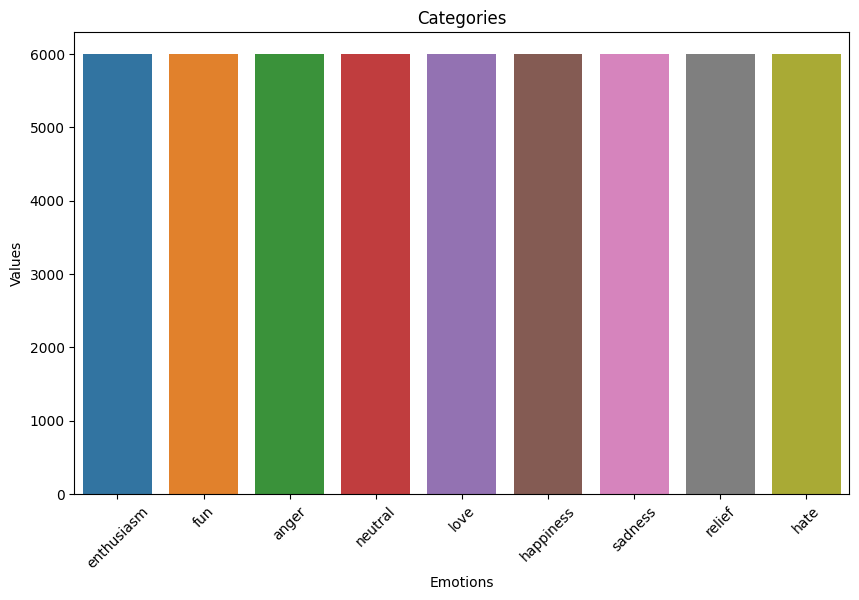

In [36]:
plt.figure(figsize=(10,6))
sns.barplot(x=df['Emotion'].value_counts().index,y=df['Emotion'].value_counts().values)
plt.xlabel('Emotions')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.title('Categories')
plt.show()

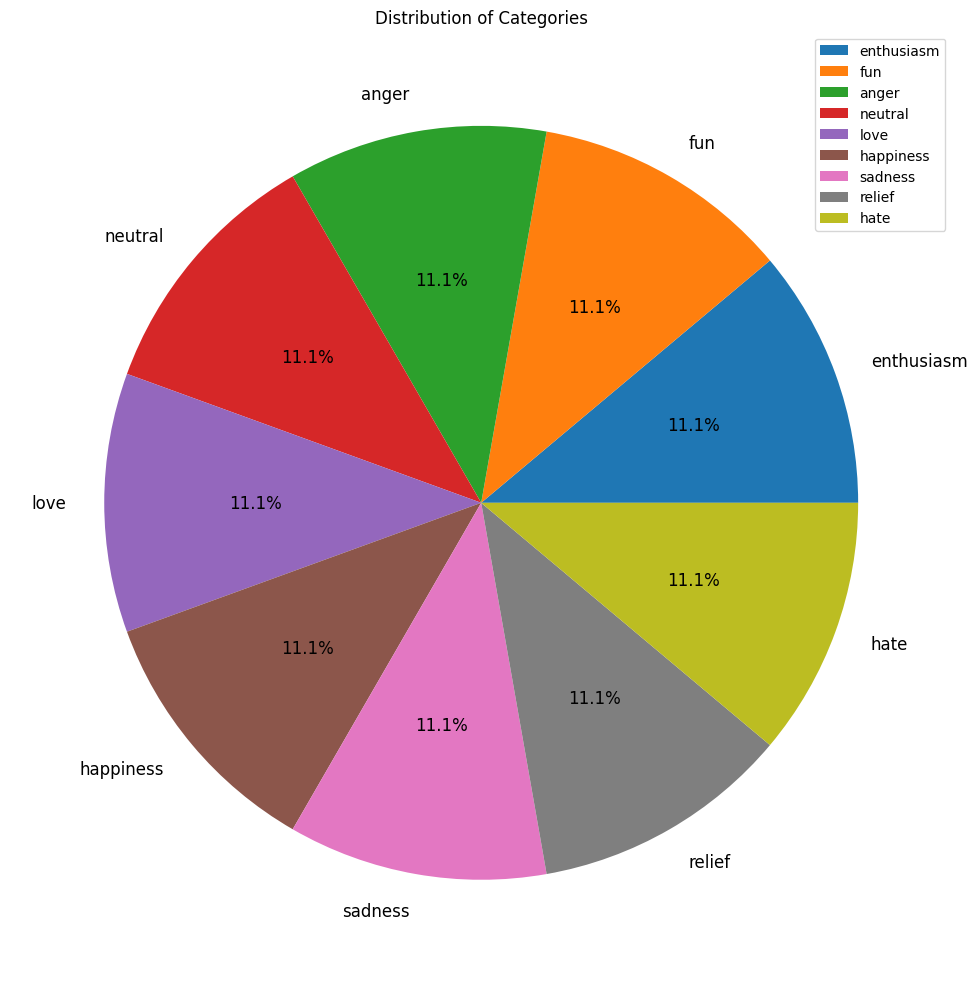

In [38]:
plt.figure(figsize=(10,10))
plt.pie(df['Emotion'].value_counts().values, labels=df['Emotion'].value_counts().index, autopct='%1.1f%%',textprops={'fontsize': 12})
plt.title('Distribution of Categories')
plt.legend(df['Emotion'].value_counts().index,loc="upper right", fontsize=10)
plt.tight_layout()
plt.show()

# Word Cloud for Emotion Categories

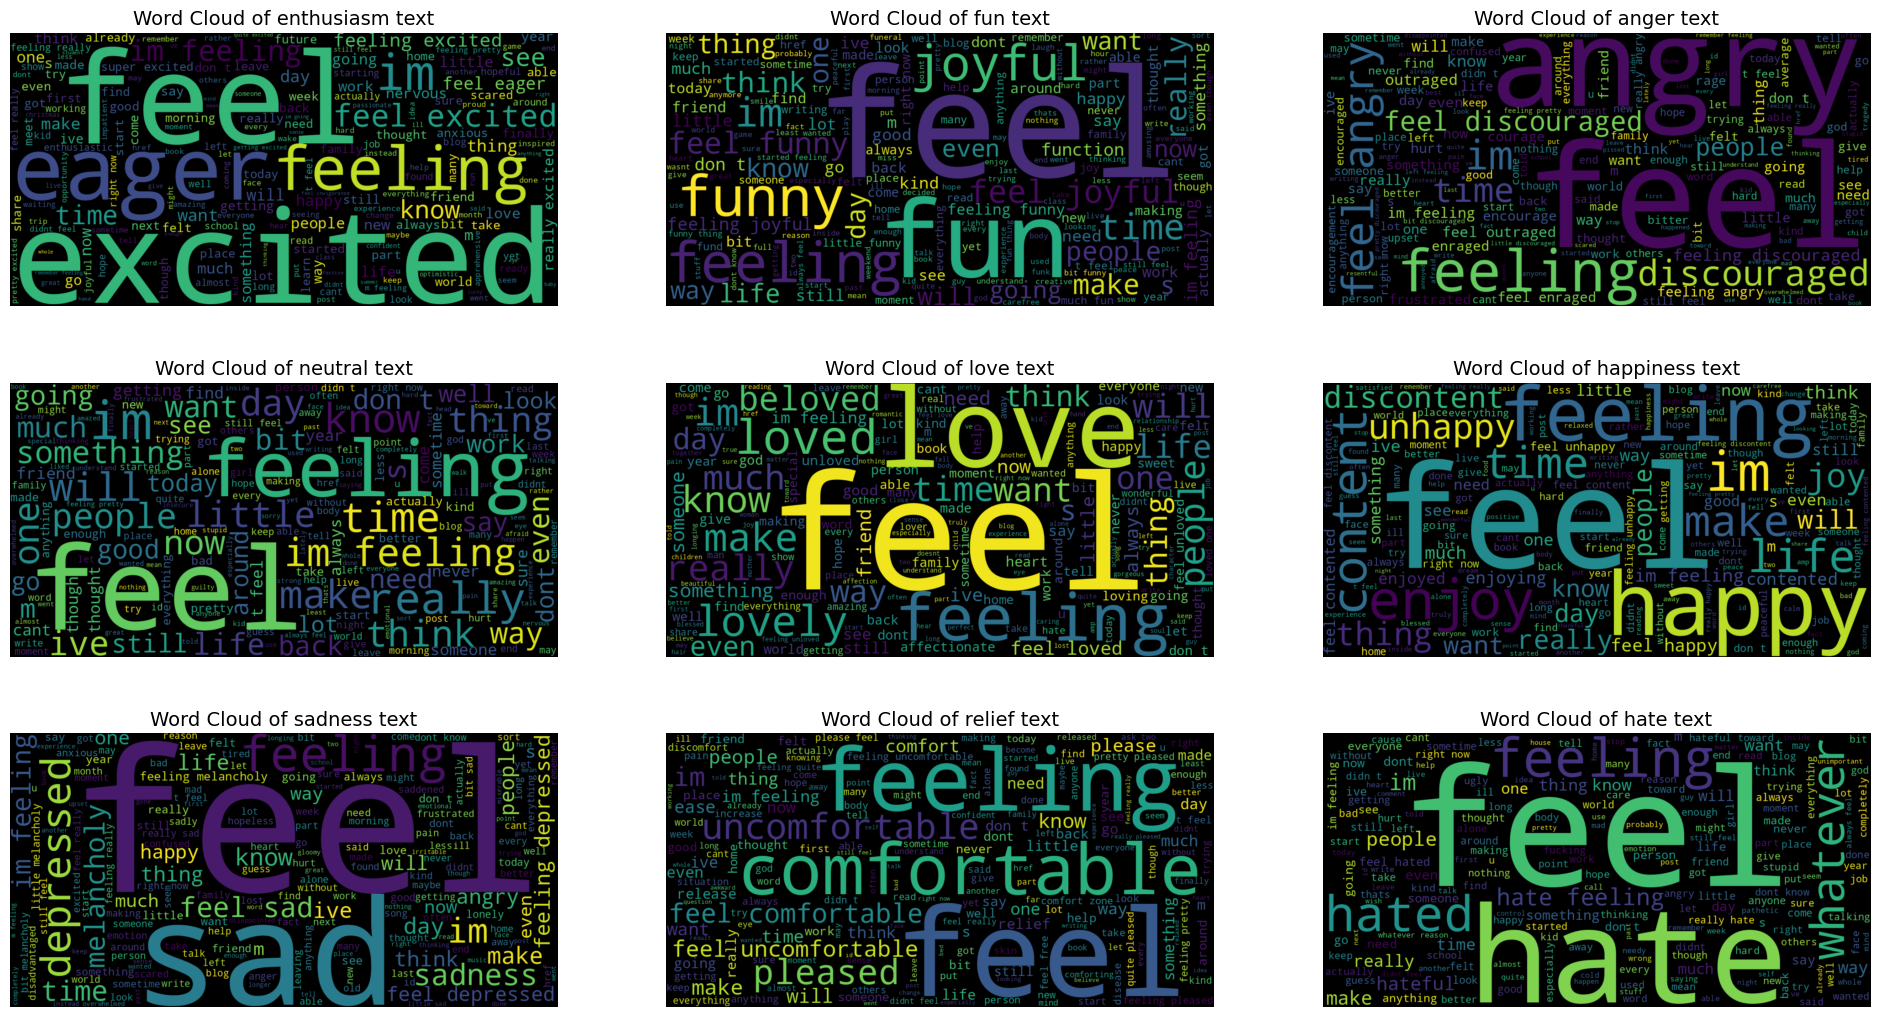

In [39]:
Emotions=df['Emotion'].unique()
plt.figure(figsize=(24,22))
for ind,emotion in enumerate(Emotions,start=1):
    combined=' '.join(df[df['Emotion']==emotion]['Text'])
    word_cloud=WordCloud(width=1200, height=600, background_color='black').generate(combined)
    plt.subplot(5,3,ind)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title(f'Word Cloud of {emotion} text',fontsize=14)
    plt.axis('off')

In [40]:
print(nltk.data.path)

['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/usr/share/nltk_data']


# Text Preprocessing:
- Expand contraction
- Remove URLs
- Remove special characters and punctuations
- Remove extra whitespaces
- Remove numerical values
- Convert to lowercase
- Tokenize text
- Remove stopwords
- Lemmatize tokens
- Join tokens back to a single string

In [22]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [23]:
def text_preprocess(text):
    text = contractions.fix(text)

    text = re.sub(r'http\S+|www\S+', '', text)

    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    text = re.sub(r'\d+', '', text)

    text = text.lower()

    tokens = word_tokenize(text)

    tokens = [word for word in tokens if word not in stop_words]

    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    processed_text = ' '.join(tokens)

    return processed_text

In [24]:
df['Preprocess_text']=df['Text'].apply(text_preprocess)

# Label Encoding

In [25]:
encoder=LabelEncoder()
df['Label']=encoder.fit_transform(df['Emotion'])

In [26]:
label_mapping = dict(zip(df["Label"], df["Emotion"]))
print("Label Mapping:", label_mapping)

Label Mapping: {1: 'enthusiasm', 2: 'fun', 0: 'anger', 6: 'neutral', 5: 'love', 3: 'happiness', 8: 'sadness', 7: 'relief', 4: 'hate'}


In [27]:
df.isna().sum()

Text               0
Emotion            0
Preprocess_text    0
Label              0
dtype: int64

In [28]:
df.shape

(54000, 4)

# TF-IDF Vectorization  


In [71]:
tfidf_vectorizer = TfidfVectorizer()

x=tfidf_vectorizer.fit_transform(df['Preprocess_text'])
y=df['Label']
print(x.shape)
print(y.shape)

(54000, 23644)
(54000,)


# Train-Test Split 

In [72]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=42)

In [73]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(48600, 23644)
(48600,)
(5400, 23644)
(5400,)


# Setting Up Callbacks for Model Training
## **Callback Details**

1. **ModelCheckpoint**  
   - Saves the best-performing model based on validation accuracy.  
2. **TensorBoard**  
   - Logs training metrics for visualization using TensorBoard.  

In [29]:
checkpoint = ModelCheckpoint('emotion-analysis.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False)

tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

# MLP: MultiLayer Perceptron

In [134]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(x_train.shape[1],)),  
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(9, activation='softmax')  
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compiling the Model

In [135]:
model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

## Model Summary

In [136]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                     │ (None, 256)                 │       6,053,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,096,649 (23.26 MB)

 Trainable params: 6,095,753 (23.25 MB)

 Non-trainable params: 896 (3.50 KB)

## Training the Model

In [137]:
%%time
history = model.fit(x_train, y_train,
                   validation_data=(x_test,y_test),
                   batch_size=16,
                   epochs=10,
                   callbacks=[tensorboard, checkpoint]
                  )

Epoch 1/10
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.1553 - loss: 2.5477
Epoch 1: val_accuracy improved from -inf to 0.69407, saving model to emotion-analysis.keras
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 462s 150ms/step - accuracy: 0.1553 - loss: 2.5477 - val_accuracy: 0.6941 - val_loss: 1.3626
Epoch 2/10
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4225 - loss: 1.6663
Epoch 2: val_accuracy improved from 0.69407 to 0.87778, saving model to emotion-analysis.keras
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - accuracy: 0.4226 - loss: 1.6663 - val_accuracy: 0.8778 - val_loss: 0.7044
Epoch 3/10
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6711 - loss: 1.0264
Epoch 3: val_accuracy improved from 0.87778 to 0.94444, saving model to emotion-analysis.keras
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - accuracy: 0.6711 - loss: 1.0263 - val_accuracy: 0.9444 - val_loss: 0.3906
Epoch 4/10
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7781 - loss: 0.71

## Accuracy Visualization
The accuracy trends for both training and validation datasets.

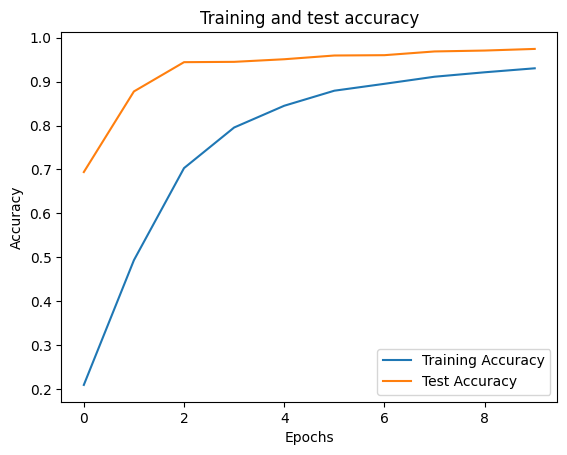

In [138]:
plt.title('Training and test accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Loss Visualization
The loss trends for both training and validation datasets.

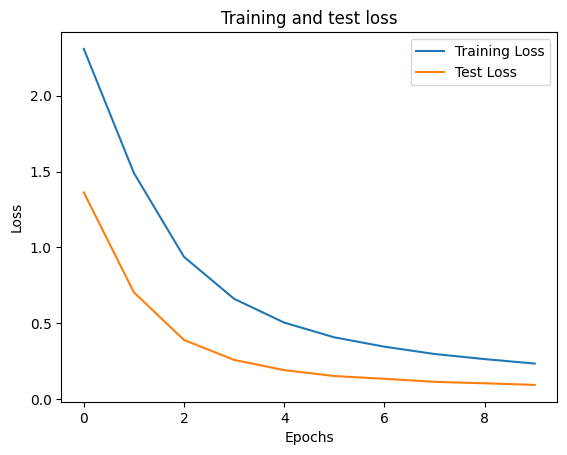

In [139]:
plt.title('Training and test loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Making Predictions

In [140]:
predictions = model.predict(x_test)  
print(predictions)

169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step
[[1.2341501e-05 4.4798621e-06 9.5934738e-06 ... 2.8190968e-04
  2.3838897e-05 3.4529262e-06]
 [1.4475700e-03 1.4435122e-04 1.6461265e-04 ... 5.2803937e-02
  7.9198065e-04 9.7637159e-05]
 [1.3019383e-07 1.7436877e-08 3.4234250e-07 ... 3.7043984e-07
  9.3534481e-08 9.9999893e-01]
 ...
 [9.8593569e-01 4.7732622e-04 1.2546420e-04 ... 7.4832374e-03
  2.3435550e-04 1.3389159e-03]
 [1.6371107e-05 9.9986863e-01 1.7612747e-05 ... 2.3769941e-05
  1.2823569e-05 2.4898643e-05]
 [1.1353056e-05 9.9986839e-01 5.7327843e-06 ... 2.2559245e-05
  1.7377261e-05 3.1381194e-05]]


In [146]:
predictions.shape

(5400, 9)

## Evaluation on Training Data

In [141]:
train_loss, train_accuracy = model.evaluate(x_train,y_train, verbose=1)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

1519/1519 ━━━━━━━━━━━━━━━━━━━━ 61s 40ms/step - accuracy: 0.9974 - loss: 0.0140
Train Loss: 0.014461992308497429
Train Accuracy: 0.997551441192627


## Evaluation on Testing Data

In [142]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9717 - loss: 0.0985
Test Loss: 0.09466637670993805
Test Accuracy: 0.9746296405792236


## Classification Report
- Precision
- Recall
- F1-Score
- Support

In [143]:
y = np.argmax(predictions, axis=1)
cr = classification_report(y_true=y_test, y_pred=y)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       594
           1       1.00      1.00      1.00       617
           2       1.00      0.97      0.98       587
           3       0.98      0.94      0.96       631
           4       0.99      0.97      0.98       588
           5       0.99      0.97      0.98       580
           6       0.85      1.00      0.92       601
           7       0.99      0.97      0.98       595
           8       1.00      0.97      0.98       607

    accuracy                           0.97      5400
   macro avg       0.98      0.97      0.98      5400
weighted avg       0.98      0.97      0.98      5400



## Confusion Matrix

In [144]:
print("Confusion Matrix:")
cm=confusion_matrix(y_true=y_test, y_pred=y)
print(cm)

Confusion Matrix:
[[588   0   0   0   0   0   6   0   0]
 [  0 616   0   0   0   0   1   0   0]
 [  0   0 567   1   0   0  18   1   0]
 [  0   0   0 595   0   0  32   4   0]
 [  2   0   0   6 571   0   8   1   0]
 [  1   0   0   1   4 562  10   2   0]
 [  0   0   0   1   0   0 600   0   0]
 [  2   0   0   0   0   0  18 575   0]
 [  1   0   0   2   0   3  12   0 589]]


Confusion Matrix


<Axes: >

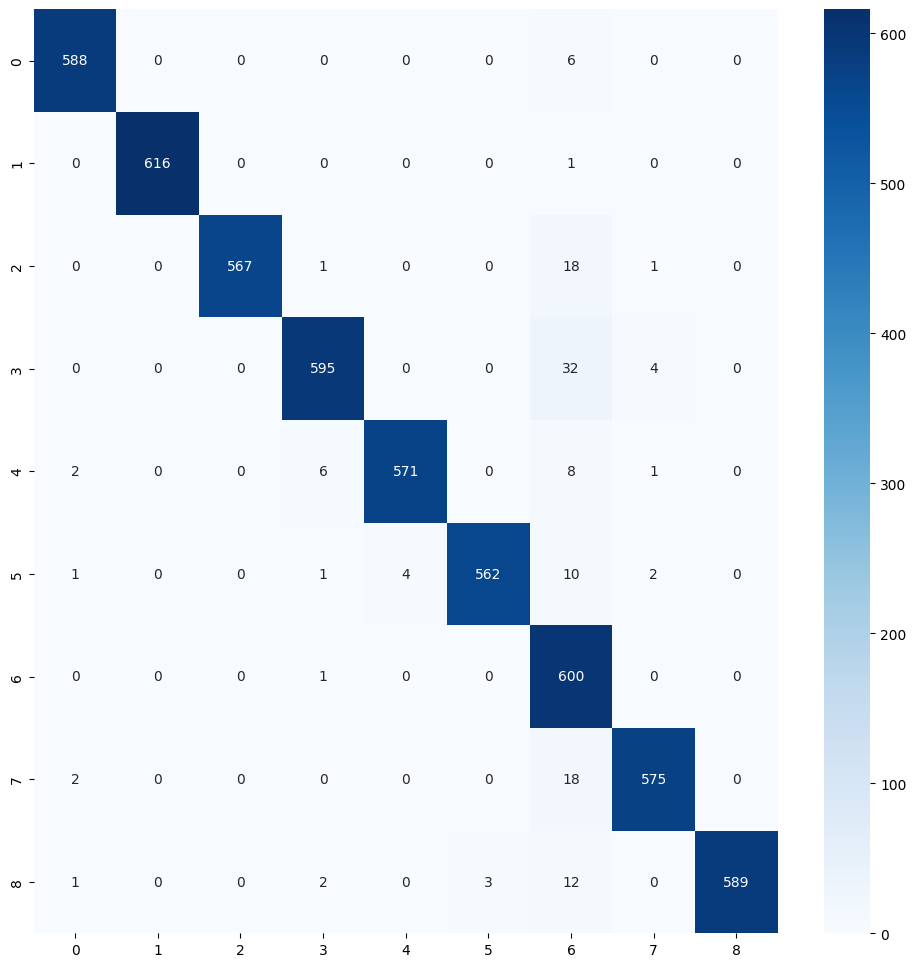

In [145]:
print('Confusion Matrix')
cm_df = pd.DataFrame(cm, columns=y_test.unique())
plt.figure(figsize=(12,12))
sns.heatmap(cm_df, annot=True, fmt='d',cmap='Blues', xticklabels=set(y_train), yticklabels=set(y_train))

# Text Tokenization  

In [30]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df["Preprocess_text"])
sequences = tokenizer.texts_to_sequences(df["Preprocess_text"])

In [31]:
maxlen = max(len(tokens) for tokens in sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 45


# Padding Sequences  

In [32]:
padded_sequences=pad_sequences(sequences, maxlen=maxlen)

# Train-Test Split

In [33]:
x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm=train_test_split(padded_sequences, df['Label'], test_size=0.1, random_state=42)

In [34]:
print(x_train_lstm.shape)
print(y_train_lstm.shape)
print(x_test_lstm.shape)
print(y_test_lstm.shape)

(48600, 45)
(48600,)
(5400, 45)
(5400,)


In [35]:
x_train_lstm

array([[    0,     0,     0, ...,     2,    21,   686],
       [    0,     0,     0, ...,  1371,    93,  5960],
       [    0,     0,     0, ...,   125,    97,   848],
       ...,
       [    0,     0,     0, ..., 19766,   195,   790],
       [    0,     0,     0, ...,  1315,    32,    56],
       [    0,     0,     0, ...,  3305,   853,   268]], dtype=int32)

In [36]:
max_vocab=len(tokenizer.word_index) + 1

In [37]:
print(maxlen)
print(max_vocab)

45
23667


# Recurrent Neural Network (RNN) with LSTM

In [38]:
model_lstm = Sequential([
    Embedding(input_dim=max_vocab, output_dim=128, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(9, activation='softmax')  
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Compiling the Model

In [39]:
model_lstm.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

## Model Summary

In [40]:
model_lstm.build(input_shape=(None, maxlen))
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 45, 128)             │       3,029,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 45, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             297 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,171,913 (12.10 MB)

 Trainable params: 3,171,849 (12.10 MB)

 Non-trainable params: 64 (256.00 B)

## Training the Model

In [41]:
%%time
history_lstm = model_lstm.fit(x_train_lstm, y_train_lstm,
                   validation_data=(x_test_lstm,y_test_lstm),
                   batch_size=16,
                   epochs=10,
                   callbacks=[tensorboard, checkpoint]
                  )

Epoch 1/10
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.2565 - loss: 1.9728
Epoch 1: val_accuracy improved from -inf to 0.94037, saving model to emotion-analysis.keras
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 608s 197ms/step - accuracy: 0.2566 - loss: 1.9727 - val_accuracy: 0.9404 - val_loss: 0.4880
Epoch 2/10
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8368 - loss: 0.6523
Epoch 2: val_accuracy improved from 0.94037 to 0.96926, saving model to emotion-analysis.keras
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 596s 196ms/step - accuracy: 0.8368 - loss: 0.6523 - val_accuracy: 0.9693 - val_loss: 0.1883
Epoch 3/10
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9105 - loss: 0.3690
Epoch 3: val_accuracy improved from 0.96926 to 0.98056, saving model to emotion-analysis.keras
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 595s 196ms/step - accuracy: 0.9105 - loss: 0.3689 - val_accuracy: 0.9806 - val_loss: 0.0992
Epoch 4/10
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9423 - lo

## Accuracy Visualization
The accuracy trends for both training and validation datasets.

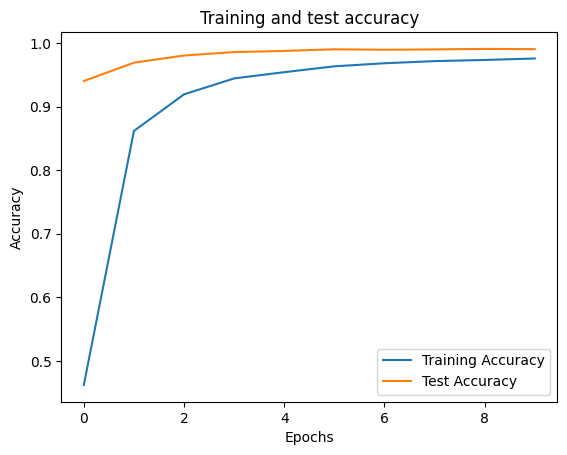

In [61]:
plt.title('Training and test accuracy')
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Loss Visualization
The loss trends for both training and validation datasets.

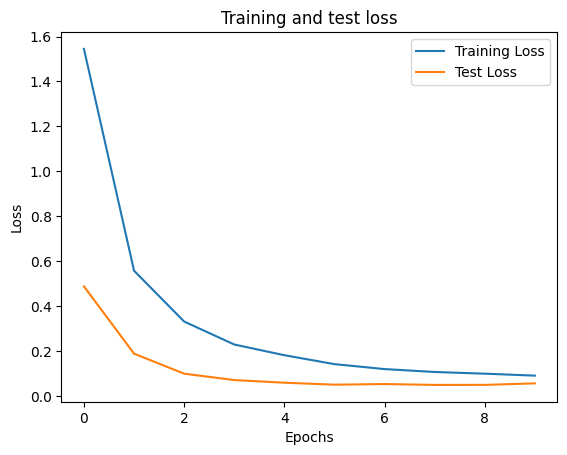

In [62]:
plt.title('Training and test loss')
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Making Predictions

In [63]:
predictions_lstm = model_lstm.predict(x_test_lstm)  
print(predictions_lstm)

169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step
[[1.87569370e-07 4.24245081e-06 5.20137348e-07 ... 3.54207629e-07
  2.40341456e-06 7.57283078e-06]
 [5.69931387e-07 8.14300074e-06 1.37332177e-06 ... 1.44167689e-06
  8.71013344e-06 1.11589434e-05]
 [2.58657309e-08 1.56292600e-07 9.52491330e-09 ... 3.76281726e-08
  3.84743659e-09 9.99999523e-01]
 ...
 [9.99849916e-01 1.18835296e-05 2.96960370e-05 ... 5.68669675e-05
  2.44261628e-06 2.63665734e-05]
 [1.65868670e-07 9.99994874e-01 7.23861291e-08 ... 3.67322883e-07
  1.12799569e-07 3.58314446e-06]
 [1.52679675e-07 9.99994874e-01 6.73556926e-08 ... 4.16673004e-07
  1.00495896e-07 3.44288060e-06]]


In [64]:
predictions_lstm.shape

(5400, 9)

## Evaluation on Training Data

In [65]:
train_loss_lstm, train_accuracy_lstm = model_lstm.evaluate(x_train_lstm, y_train_lstm, verbose=1)
print(f"Train Loss: {train_loss_lstm}")
print(f"Train Accuracy: {train_accuracy_lstm}")

1519/1519 ━━━━━━━━━━━━━━━━━━━━ 63s 41ms/step - accuracy: 0.9988 - loss: 0.0047
Train Loss: 0.005103435833007097
Train Accuracy: 0.9987860321998596


## Evaluation on Testing Data

In [66]:
test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(x_test_lstm, y_test_lstm, verbose=1)
print(f"Test Loss: {test_loss_lstm}")
print(f"Test Accuracy: {test_accuracy_lstm}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9908 - loss: 0.0534
Test Loss: 0.05618935450911522
Test Accuracy: 0.9905555844306946


## Classification Report
- Precision
- Recall
- F1-Score
- Support

In [67]:
y_lstm = np.argmax(predictions_lstm, axis=1)
cr_lstm = classification_report(y_true=y_test_lstm, y_pred=y_lstm)
print(cr_lstm)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       594
           1       1.00      1.00      1.00       617
           2       1.00      0.99      1.00       587
           3       0.99      1.00      0.99       631
           4       1.00      0.98      0.99       588
           5       1.00      0.99      0.99       580
           6       0.94      1.00      0.97       601
           7       0.99      0.97      0.98       595
           8       1.00      0.99      0.99       607

    accuracy                           0.99      5400
   macro avg       0.99      0.99      0.99      5400
weighted avg       0.99      0.99      0.99      5400



## Confusion Matrix

In [68]:
print("Confusion Matrix:")
cm_lstm=confusion_matrix(y_true=y_test_lstm, y_pred=y_lstm)
print(cm_lstm)

Confusion Matrix:
[[593   0   0   0   0   0   1   0   0]
 [  0 617   0   0   0   0   0   0   0]
 [  0   0 582   1   0   0   3   1   0]
 [  0   0   0 628   0   0   2   1   0]
 [  2   0   0   4 577   0   5   0   0]
 [  0   0   0   0   1 574   5   0   0]
 [  0   0   0   0   0   0 600   1   0]
 [  1   0   0   0   0   0  15 579   0]
 [  0   1   0   1   0   2   4   0 599]]


Confusion Matrix


<Axes: >

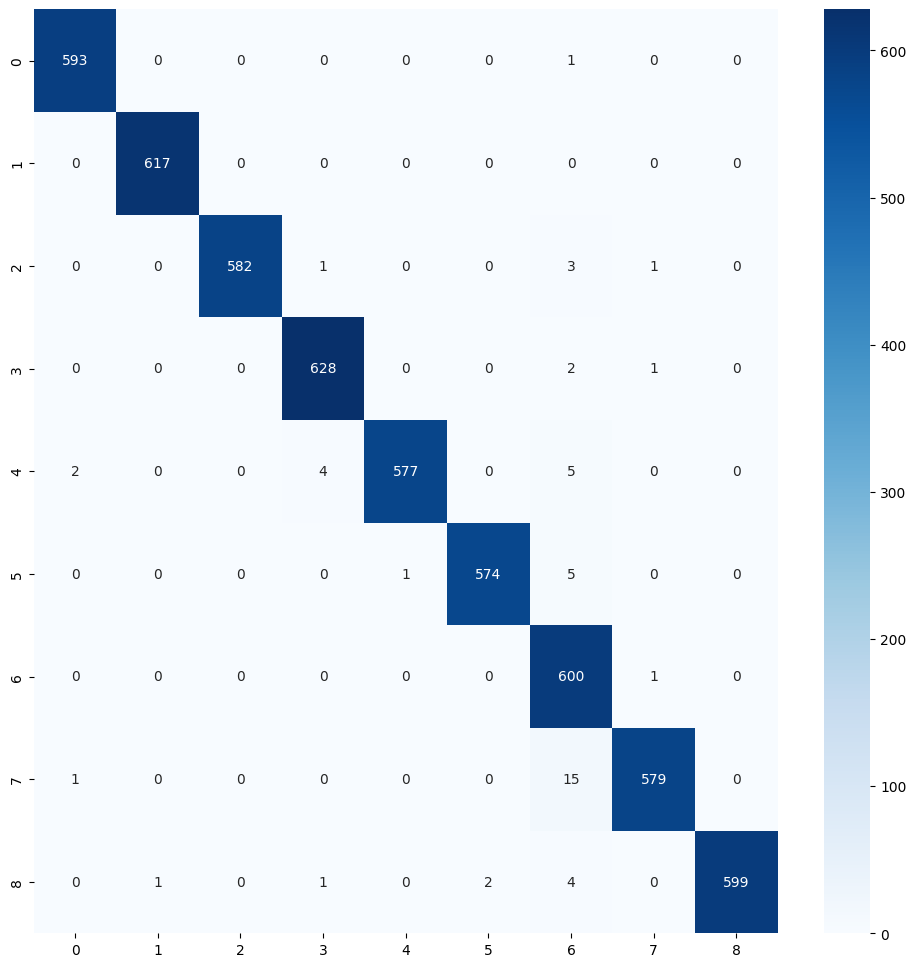

In [69]:
print('Confusion Matrix')
cm_df_lstm = pd.DataFrame(cm_lstm, columns=y_test_lstm.unique())
plt.figure(figsize=(12,12))
sns.heatmap(cm_df_lstm, annot=True, fmt='d',cmap='Blues', xticklabels=set(y_train_lstm), yticklabels=set(y_train_lstm))